## Maintenance de la segmentation

Maintenant qu'on a procédé à cette segmentation sur l'ensemble de nos données, on va faire des tests afin d'évaluer la fréquence à laquelle cette segmentation doit être renouvelée afin d'avoir une segmentation efficace et pertinente. Pour cela on va donc séparer notre dataset dans le temps afin de constater la durée de stabilité des clusters. On va donc calculer ces derniers toutes les semaines et les comparer pour voir au bout de combien de temps les clusters sont trop différents et doivent être renouvelés.

Pour ces tests, on va uniquement se baser sur les features RFM.

Commençons donc par créer de nouveaux datasets avec des séparations temporelles. Les dates des commandes vont du 4 septembre 2016 au 29 août 2018, on va donc prendre une date clé environ au milieu, soit un an avant la date de fin, le 29 août 2017. On va créer nos premiers clusters sur ce dataset, puis on incrémentera semaine par semaine et on étudiera l'évolution.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import rcParams
import matplotlib.pyplot as plt

from datetime import datetime  
from datetime import timedelta 

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score as ARI

In [2]:
customers = pd.read_csv('olist_customers_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv')
payments = pd.read_csv('olist_order_payments_dataset.csv')

In [3]:
#On garde de nouveau uniquement les commandes livrées.
orders = orders.loc[orders['order_status']=='delivered']
customers = customers.loc[customers['customer_id'].isin(orders['customer_id'])]
payments = payments.loc[payments['order_id'].isin(orders['order_id'])]

On va faire le tri temporel sur le dataset orders car il contient les dates, puis on gardera uniquement les features pour le RFM et chaque RFM correspondra bien uniquement aux commandes du dataset car on fera le merge sur celui-ci.

In [4]:
orders = orders[['order_id','customer_id','order_purchase_timestamp']]
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders

,order_id,customer_id,order_purchase_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39
...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,2017-03-09 09:54:05
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,2018-02-06 12:58:58
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,2017-08-27 14:46:43
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,2018-01-08 21:28:27


In [5]:
#On crée une fonction qui calcule les Dn en fonction de la date clé
def Dn(limit,n) : 
    D = orders.loc[orders['order_purchase_timestamp']<pd.to_datetime(limit) + timedelta(days=7)*n]
    return D

La dernière date de notre dataset étant le 29 août, nous aurons tous le dataset au bout de 46 semaines, c'est donc notre nmax.

In [6]:
#Calculons les 20 premiers datasets
data_list = []
for i in range (20) :
    data_list.append(Dn('2017-08-29',i))

In [7]:
data_list[0]

,order_id,customer_id,order_purchase_timestamp
5,a4591c265e18cb1dcee52889e2d8acc3,503740e9ca751ccdda7ba28e9ab8f608,2017-07-09 21:57:05
7,6514b8ad8028c9f2cc2374ded245783f,9bdf08b4b3b52b5526ff42d37d47f222,2017-05-16 13:10:30
8,76c6e866289321a7c93b82b54852dc33,f54a9f0e6b351c431402b8461ea51999,2017-01-23 18:29:09
9,e69bfb5eb88e0ed6a785585b27e16dbf,31ad1d1b63eb9962463f764d4e6e0c9d,2017-07-29 11:55:02
10,e6ce16cb79ec1d90b1da9085a6118aeb,494dded5b201313c64ed7f100595b95c,2017-05-16 19:41:10
...,...,...,...
99426,7cc85185736ea7f2d8bc09af7a47cab7,9e870ea67399650e8c3545a25d13e4d0,2017-05-15 09:46:26
99434,aa04ef5214580b06b10e2a378300db44,f01a6bfcc730456317e4081fe0c9940e,2017-01-27 00:30:03
99435,880675dff2150932f1601e1c07eadeeb,47cd45a6ac7b9fb16537df2ccffeb5ac,2017-02-23 09:05:12
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,2017-03-09 09:54:05


On peut déjà noter que ce dataset comprenant toutes les commandes passées avant le 29/28/17 ne contient que 21814 lignes, soit seulement 22% du dataset.

On crée une nouvelle fonction qui pour chaque Dn va calculer le RFM associé. Pour cela on recalcule déjà les montants pour chaque commande, car ceux ci sont fixes et on gardera seulements ceux qui nous intéressent à chaque fois, puis on va effectuer les merge et calculer la fréquence et la récence à partir des datasets individuels car les valeurs vont varier.

In [8]:
# Calcule les montants de chaque commande
totaux = payments[['order_id','payment_value']].groupby('order_id', as_index=False).sum()
totaux.rename({'payment_value':'total_payment'},axis=1,inplace=True)
totaux

,order_id,total_payment
0,00010242fe8c5a6d1ba2dd792cb16214,72.19
1,00018f77f2f0320c557190d7a144bdd3,259.83
2,000229ec398224ef6ca0657da4fc703e,216.87
3,00024acbcdf0a6daa1e931b038114c75,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,218.04
...,...,...
96472,fffc94f6ce00a00581880bf54a75a037,343.40
96473,fffcd46ef2263f404302a634eb57f7eb,386.53
96474,fffce4705a9662cd70adb13d4a31832d,116.85
96475,fffe18544ffabc95dfada21779c9644f,64.71


In [9]:
def RFM_calc(data):
    
    # On merge Orders avec Montants pour avoir les paiements par commande
    merged = data.merge(totaux)
    
    #On merge ensuite avec Customers afin d'avoir les clients uniques
    merged = merged.merge(customers[['customer_id','customer_unique_id']])
    
    #On calcule le nombre de commande par client pour la fréquence
    F = pd.DataFrame(merged['customer_unique_id'].value_counts())
    F.reset_index(inplace=True)
    F.rename({'customer_unique_id':'count','index':'customer_unique_id'}, axis=1,inplace=True)
    
    #On calcule la récence pour chaque client unique
    R = merged[['customer_unique_id','order_purchase_timestamp']].groupby('customer_unique_id',as_index=False).max()
    last_date = merged['order_purchase_timestamp'].max()
    R['recence'] = pd.to_datetime(last_date) - pd.to_datetime(R['order_purchase_timestamp'])
    R.drop('order_purchase_timestamp',axis=1,inplace=True)

    #On calcule le montant total par client
    M = merged[['customer_unique_id','total_payment']].groupby('customer_unique_id',as_index=False).sum()
    
    #On merge tous ces datasets
    RFMn = F.merge(M)
    RFMn = RFMn.merge(R)
    
    # On place l'id client en index
    RFMn.index = RFMn['customer_unique_id']
    RFMn.drop('customer_unique_id',axis=1,inplace=True)

    # On transforme le datetime en valeur en secondes
    RFMn ['recence'] = RFMn['recence'].apply(lambda x : x.days)

    return RFMn

In [10]:
#On applique la fonction pour calculer les datasets RFM
RFM_list = []

for i in range (20) :
    RFM_list.append(RFM_calc(data_list[i]))

In [11]:
RFM_list[0]

,count,total_payment,recence
customer_unique_id,,,
12f5d6e1cbf93dafd9dcc19095df0b3d,6,110.72,235
8d50f5eadf50201ccdcedfb9e2ac8455,4,322.12,23
4e65032f1f574189fb793bac5a867bbc,4,438.75,43
83e7958a94bd7f74a9414d8782f87628,4,73.48,235
25a560b9a6006157838aab1bdbd68624,4,131.80,141
...,...,...,...
0d936d4fc643057083df630a57c0ff03,1,80.77,122
a1aad80f12918aa399ec076ed078e5d9,1,716.65,170
a571483292f72f692cd87f2bbed988d9,1,50.51,197


On retourne ici uniquement le RFM avant tout autre traitement (StandardScaler/kmeans), car on va les séparer afin de comparer les prédictions aux valeurs réelles. En effet pour chaque Dn on va fit sur un scaler et transformer, puis fit ces données sur le Kmeans et prédire des clusters.

On commence donc avec des clusters C0 prédits à partir d'un modèle Kmeans M0 fit sur des données standardisées par un scaler STD0 à partir du RFM0 calculé à partir des données D0, sélectionnée avec notre date clé à n=0.

Pour évaluer ensuite la stabilité de nos données, on va calculer C1 de la même façon que précédemment, puis on va le comparer à l'aide d'un score ARI à un C1_prédit calculé cette fois-ci à partir du scaler STD0 et du modèle M0. Si le score ARI obtenu est supérieur à 0.8, on procède de la même façon jusqu'à ce que le score descende en dessous de 0.8, et on observe combien de temps s'est écoulé.

In [12]:
# On va fit les scalers, les stocker et créer les datasets standardisés

scaler_list = []
scaled_data_list = []
for i in range(20) :
    scaler = StandardScaler()
    scaler.fit(RFM_list[i])
    scaler_list.append(scaler)
    scaled = pd.DataFrame(scaler.transform(RFM_list[i]))
    scaled_data_list.append(scaled)

In [13]:
# On fit maintenant les modèles, on les stock et on crée un set avec les clusters

model_list = []
cluster_labels_list = []
for i in range(20) :
    model = KMeans(n_clusters=4,random_state=10)
    model.fit(scaled_data_list[i])
    labels = pd.Series(model.labels_)
    model_list.append(model)
    cluster_labels_list.append(labels)

On a maintenant nos clusters C0 à C9 calculés chacun à partir de leur dataset respectifs. On va ensuite comparer ces clusters avec les clusters prédits à partir du premier modèle pour voir au bout de combien de temps le modèle décline.

In [14]:
cluster_pred = []
#On calcule les prédictions :
for i in range (20) : 
    prediction = model_list[0].predict((scaler_list[0].transform(RFM_list[i])))
    cluster_pred.append(pd.Series(prediction))

On va maintenant comparer les clusters à l'aide du score ARI.

In [15]:
#On calcule les scores ARI entre les clusters calculés pour chaque n et les clusters prédits
ARI_scores = []
for i in range (0,20) : 
    score = ARI(cluster_labels_list[i],cluster_pred[i])
    ARI_scores.append(score)

ARI_scores = pd.DataFrame(ARI_scores)
ARI_scores.reset_index(inplace=True)
ARI_scores.rename({'index':'Semaine',0:'ARI'}, axis=1,inplace=True)
ARI_scores

,Semaine,ARI
0,0,1.000000
1,1,0.950843
2,2,0.918327
3,3,0.895485
4,4,0.846304
5,5,0.818829
6,6,0.825523
7,7,0.782104
8,8,0.765955
9,9,0.698390


On obtient ainsi les scores ARI pour chaque comparaison, on peut les réprésenter à l'aide d'un graph afin d'observer plus facilement l'évolution.

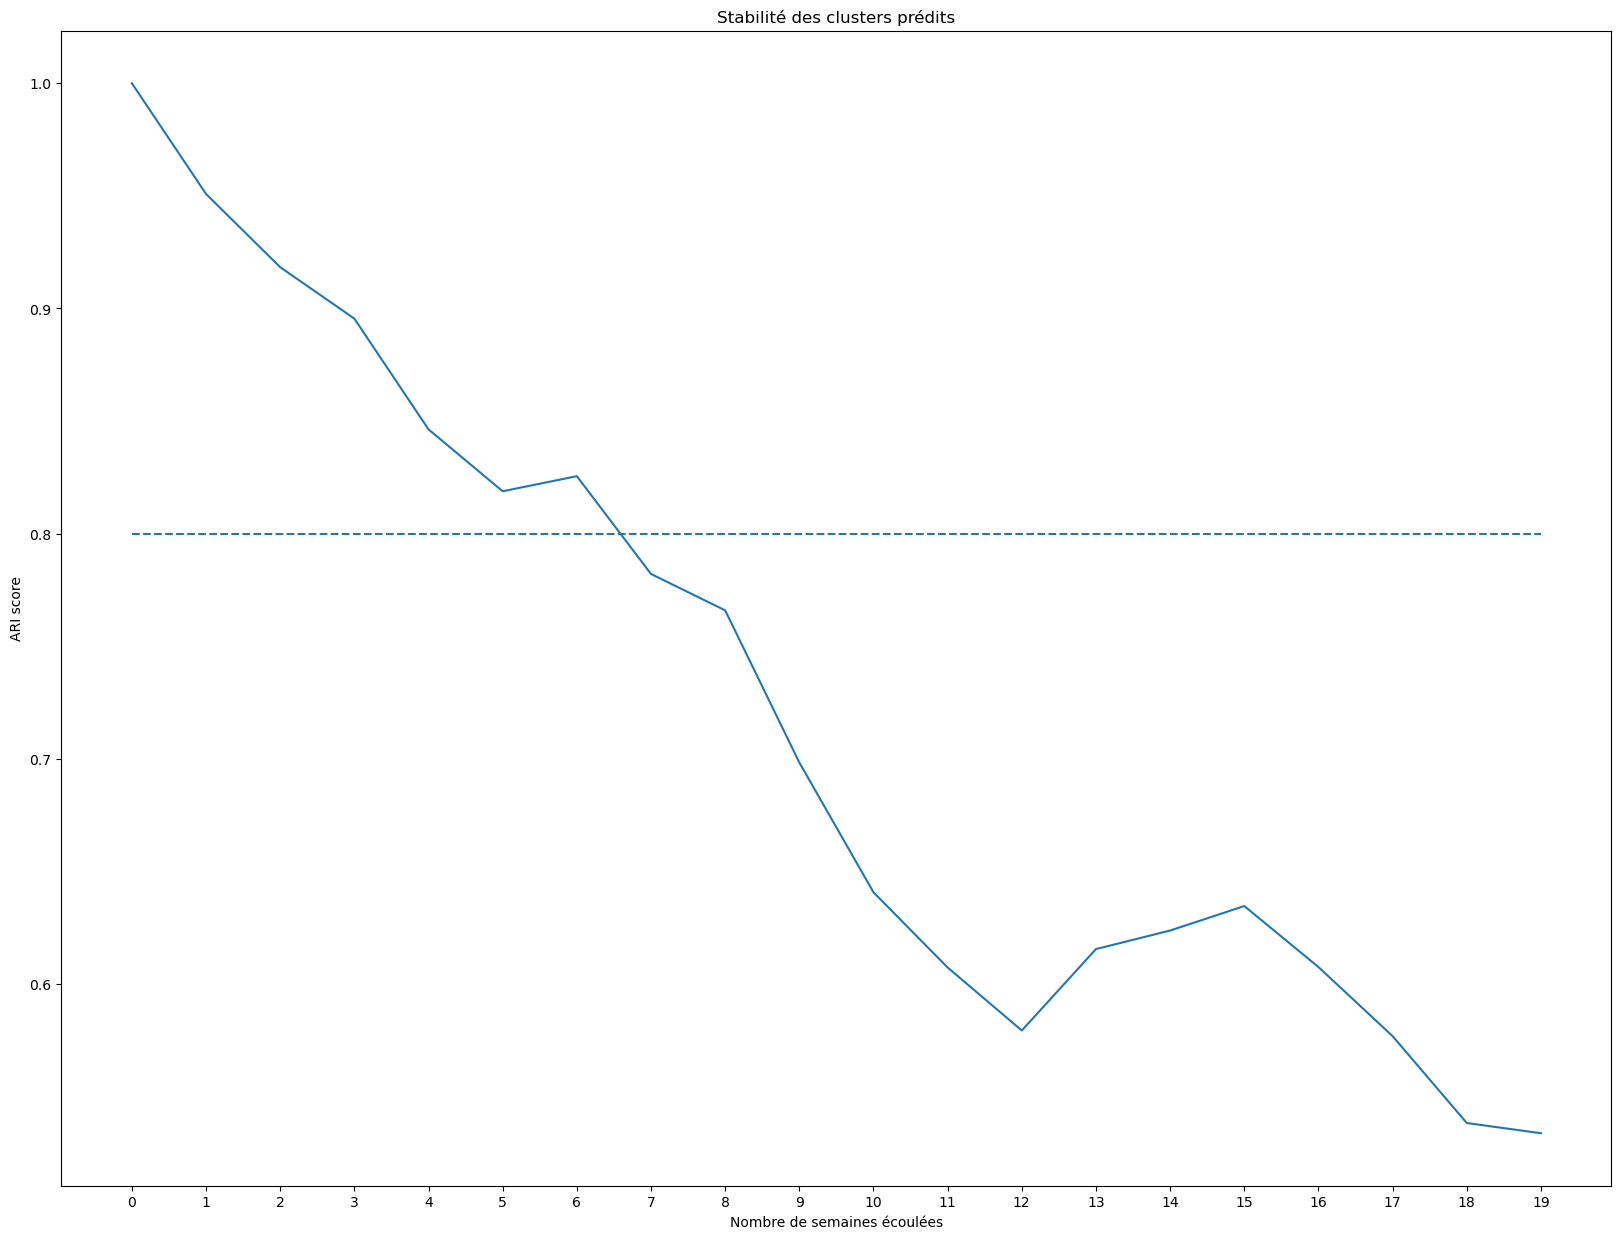

In [16]:
rcParams['figure.figsize'] = 20,15
sns.lineplot(data=ARI_scores, x='Semaine', y='ARI')
plt.hlines(0.8, xmin=0, xmax=19, linestyles = 'dashed')

plt.xlabel('Nombre de semaines écoulées') 
plt.ylabel('ARI score') 
plt.title('Stabilité des clusters prédits')
plt.xticks(ARI_scores.Semaine)
plt.show()

On peut noter sur ce graph que le score ARI passe sous la barre de 0.8 au bout de la 7e semaine.

# -----------------------------------------------------------------------------------------------------------

Etudions maintenant les résultats en répétant cette opération, en prenant une date clé différente afin de vérifier qu'on obtient les même résultats.

La première date qu'on avait pris était environ 1 an avant la fin du dataset, regardons les résultats obtenus si on prend un t0 8 mois puis 6 mois avant la fin du dataset.

Pour cela on va créer une fonction qui réutilise tout ce qu'on a décrit précédemment et sors directement le graph de l'ARI

In [17]:
def stabilite_clusters(limit) :
    
    #On crée tous les datasets nécessaires
    data_l = []
    RFM_l = []
    scaler_l = []
    scaled_data_l = []  
    model_l = []
    cluster_labels_l = []
    cluster_p = []
    ARI_sc = []
    
    for i in range (20) :
        #On crée les datasets selon la date
        data_l.append(Dn(limit,i))
        #On calcule les RFM
        RFM_l.append(RFM_calc(data_l[i]))
        #On fit les scaler et on standardise les valeurs
        scaler = StandardScaler()
        scaler.fit(RFM_l[i])
        scaled = pd.DataFrame(scaler.transform(RFM_l[i]))
        scaler_l.append(scaler)
        scaled_data_l.append(scaled)
        #De même sur le modèle et on obtient les clusters
        model = KMeans(n_clusters=4,random_state=10)
        model.fit(scaled_data_l[i])
        labels = pd.Series(model.labels_)
        model_l.append(model)
        cluster_labels_l.append(labels)

        #On calcule les prédictions :
        prediction = model_l[0].predict((scaler_l[0].transform(RFM_l[i])))
        cluster_p.append(pd.Series(prediction))
        
        #On calcule le score ARI
        score = ARI(cluster_labels_l[i],cluster_p[i])
        ARI_sc.append(score)
        
    ARI_sc = pd.DataFrame(ARI_sc)
    ARI_sc.reset_index(inplace=True)
    ARI_sc.rename({'index':'Semaine',0:'ARI'}, axis=1,inplace=True)
    
    rcParams['figure.figsize'] = 20,15
    sns.lineplot(data=ARI_sc, x='Semaine', y='ARI')
    plt.hlines(0.8, xmin=0, xmax=19, linestyles = 'dashed')
    plt.xlabel('Nombre de semaines écoulées') 
    plt.ylabel('ARI score') 
    plt.title('Stabilité des clusters prédits')
    plt.xticks(ARI_sc.Semaine)
    plt.show()
    display(ARI_sc)

Faison maintenant varier la date de départ afin d'observer si le comportement reste le même et si la durée est similaire à ce qu'on avait trouvé précédemment.

In [18]:
#Prenons les données commençant 8 mois avant la date de fin
orders['order_purchase_timestamp'].max() - timedelta(days=240)

Timestamp('2018-01-01 15:00:37')

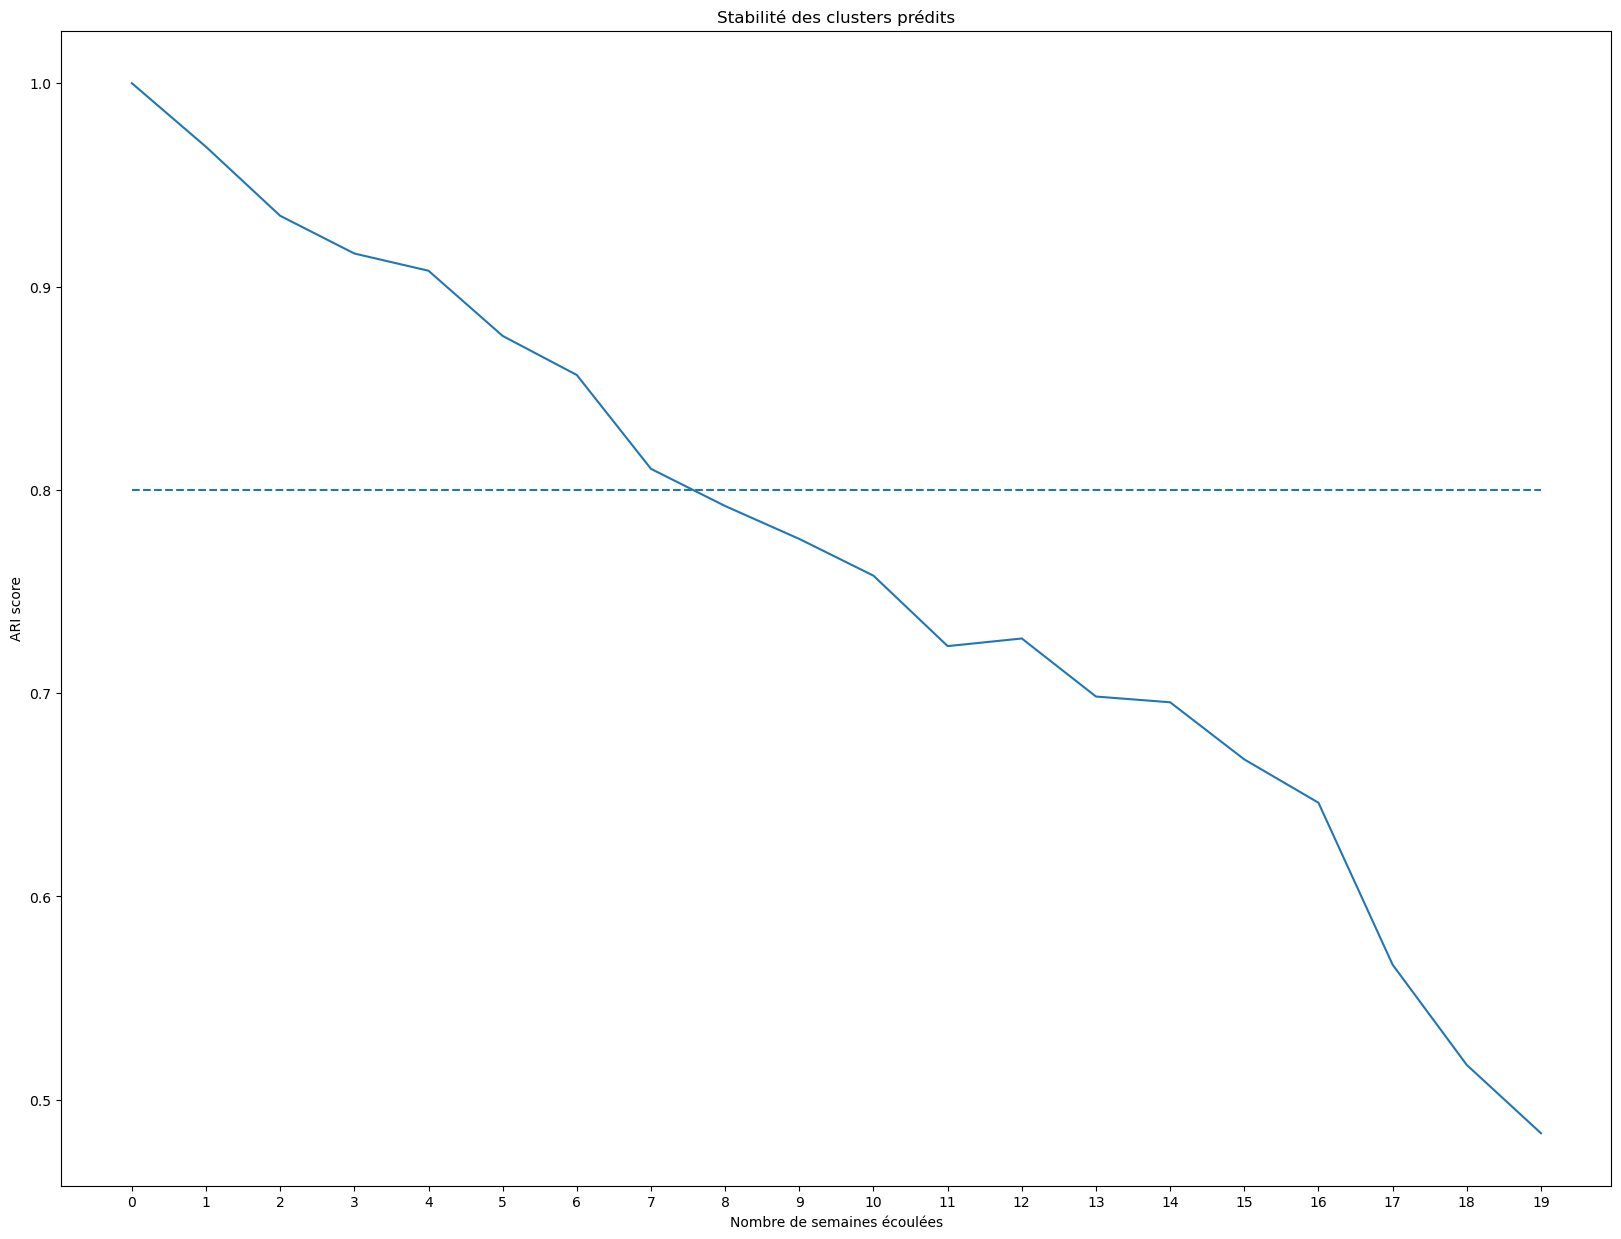

,Semaine,ARI
0,0,1.000000
1,1,0.968710
2,2,0.934789
3,3,0.916237
4,4,0.907762
5,5,0.875697
6,6,0.856475
7,7,0.810308
8,8,0.792027
9,9,0.775836


In [19]:
stabilite_clusters('2018-01-01')

On voit cette fois-ci que l'ARI passe les 0.8 entre la 7e et la 8e semaine, ce qui reste très proche de ce qu'on avait précédemment.

Regardons enfin avec une date clé 6 mois avant la date de fin.

In [20]:
orders['order_purchase_timestamp'].max() - timedelta(days=180)

Timestamp('2018-03-02 15:00:37')

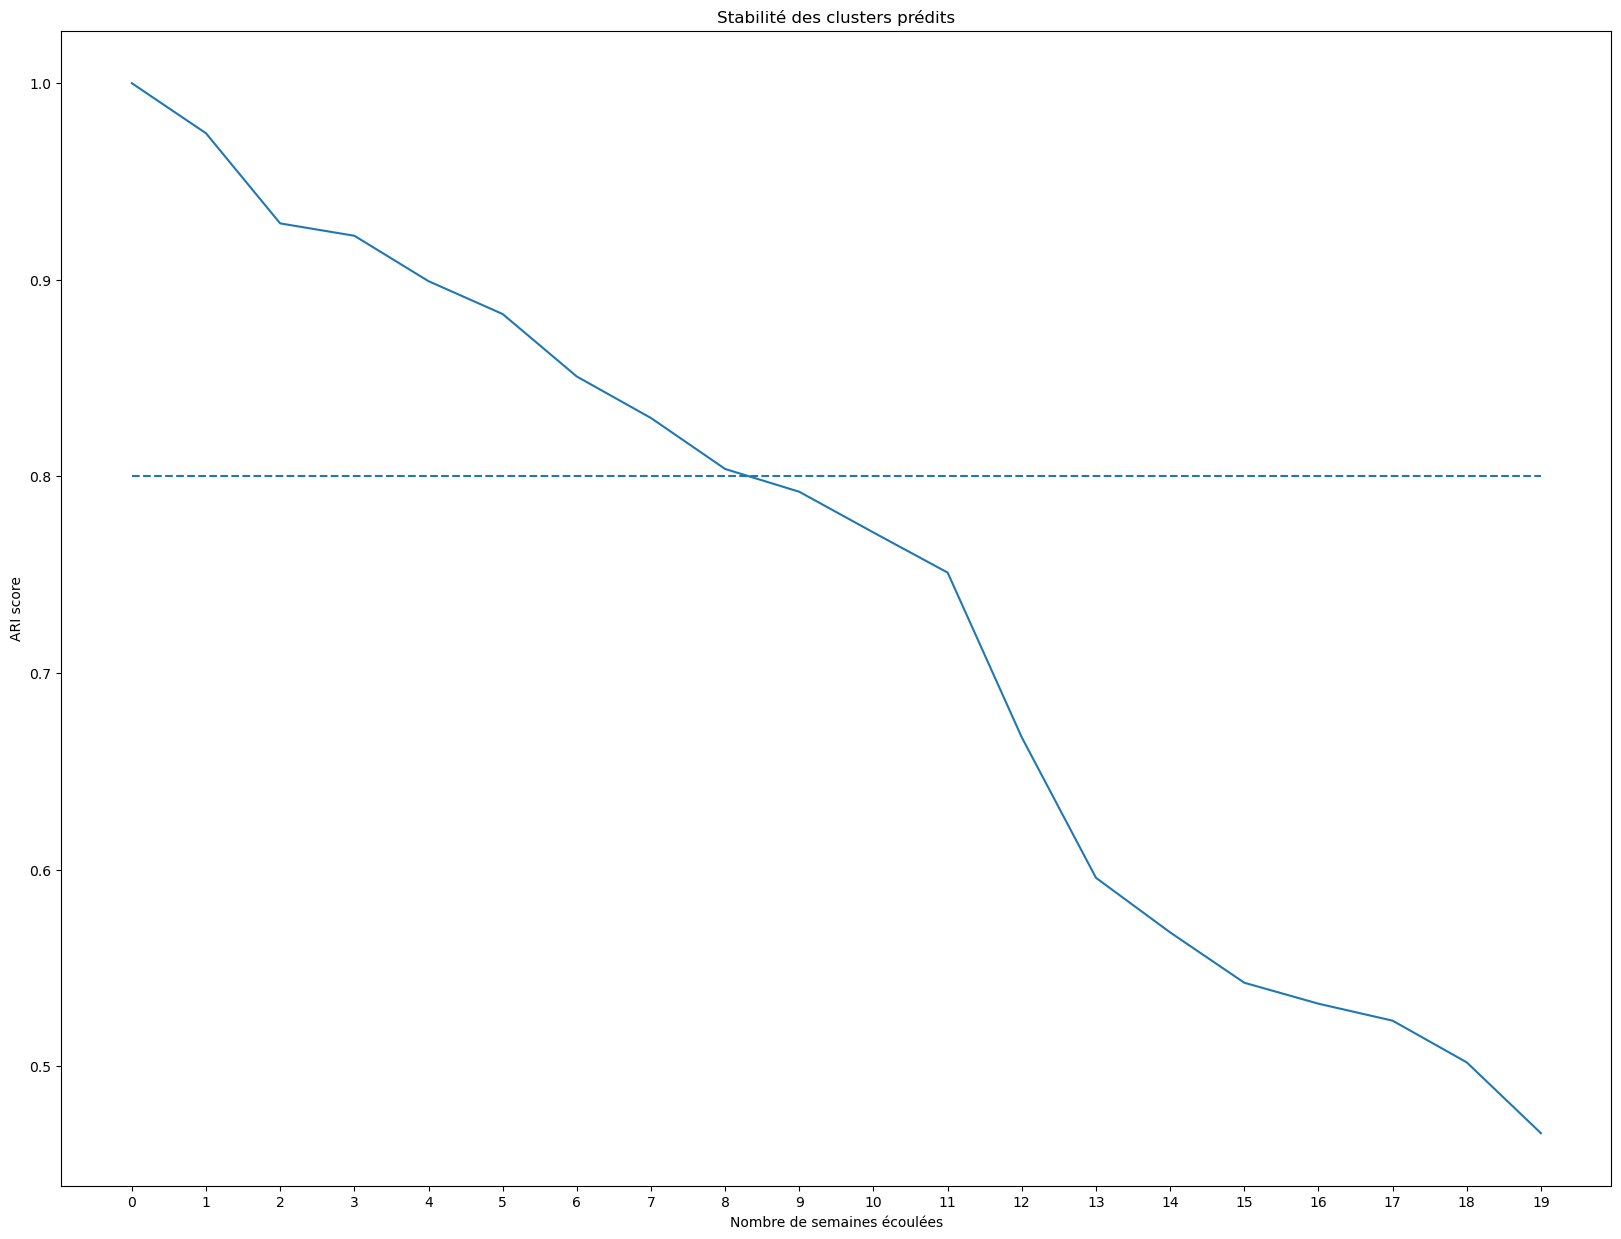

,Semaine,ARI
0,0,1.000000
1,1,0.974531
2,2,0.928685
3,3,0.922406
4,4,0.899308
5,5,0.882583
6,6,0.850791
7,7,0.829681
8,8,0.803759
9,9,0.792165


In [21]:
stabilite_clusters('2018-03-02')

On retrouve cette fois ci que le score n'est plus suffisant à partir de la 9e semaine.